In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [2]:
random_seed = 42

In [3]:
X = []
y = []
maxx = -10000
minn = 10000

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('T88_111_MASKED_GFC.npz'):
            npzfile = np.load(os.path.join(dirname, filename))
            temp = npzfile['buffer']
            tmax, tmin = np.max(temp), np.min(temp)
            if tmax > maxx:
                maxx = tmax
            if tmin < minn:
                minn = tmin
            X.append(npzfile['buffer'])
            y.append(npzfile['label'])

In [4]:
print(maxx, minn)
X = (X - minn) / (maxx - minn)

3983.4158 -515.03125


In [5]:
len(X), len(y), X[0].shape, np.max(X), np.min(X)

(436, 436, (44, 52, 44, 1), 1.0, 0.0)

In [6]:
Y = []

for i in y:
    temp = None
    if i > 0:
        if i == 0.5:
            temp = 1
        else:
            temp = 2
    else:
        temp = 0
    Y.append(temp)

In [7]:
class Result:
    def __init__(self, tag):
        self.model_tag = tag
        self.test_loss = None
        self.test_accuracy = None
        self.y_pred = None
        self.y_test = None
        self.y_pred_smote = None
        self.y_test_smote = None
        self.model_history = None

In [8]:
results = []
sample_shape = [44, 52, 44, 1]

In [9]:
def getMultiscaleBlock(prev_layer, dilation_rate):
    aconv_1 = tf.keras.layers.Conv3D(32, kernel_size=(1, 1, 1), activation="relu", padding="SAME")(prev_layer)
    aconv_1 = tf.keras.layers.BatchNormalization()(aconv_1)
#     aconv_1 = tf.keras.layers.Dropout(0.5)(aconv_1)
    
    aconv_2 = tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", dilation_rate = dilation_rate, padding="SAME")(aconv_1)
    aconv_2 = tf.keras.layers.BatchNormalization()(aconv_2)
#     aconv_2 = tf.keras.layers.Dropout(0.5)(aconv_2)
    
    aconv_3 = tf.keras.layers.Conv3D(64, kernel_size=(1, 1, 1), activation="relu", padding="SAME")(aconv_2)
    aconv_3 = tf.keras.layers.BatchNormalization()(aconv_3)
#     aconv_3 = tf.keras.layers.Dropout(0.5)(aconv_3)
    
    return aconv_3

In [10]:
def get_model(width=128, height=128, depth=64):

    inputs = keras.Input((width, height, depth, 1))

    x1 = layers.Conv3D(filters=64, kernel_size=3, activation="relu", dilation_rate = 1, padding="SAME")(inputs)
    x1 = layers.MaxPool3D(pool_size=2)(x1)
    x1 = layers.BatchNormalization()(x1)

    x2 = layers.Conv3D(filters=64, kernel_size=3, activation="relu", dilation_rate = 4, padding="SAME")(inputs)
    x2 = layers.MaxPool3D(pool_size=2)(x2)
    x2 = layers.BatchNormalization()(x2)
    
    x3 = layers.Conv3D(filters=64, kernel_size=3, activation="relu", dilation_rate = 2, padding="SAME")(inputs)
    x3 = layers.MaxPool3D(pool_size=2)(x3)
    x3 = layers.BatchNormalization()(x3)
    
    x4 = layers.Concatenate()([x1, x2, x3])

    x5 = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding="SAME")(x4)
    x5 = layers.MaxPool3D(pool_size=2)(x5)
    x5 = layers.BatchNormalization()(x5)
    
    x6 = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="SAME")(x4)
    x6 = layers.MaxPool3D(pool_size=2)(x6)
    x6 = layers.BatchNormalization()(x6)
    
    x7 = layers.Concatenate()([x5, x6])

    x8 = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="SAME")(x7)
    x8 = layers.MaxPool3D(pool_size=2)(x8)
    x8 = layers.BatchNormalization()(x8)

    x9 = layers.GlobalAveragePooling3D()(x8)
    x9 = layers.Dense(units=32, activation="relu")(x9)
    x9 = layers.Dense(units=512, activation="relu")(x9)

    outputs = layers.Dense(units=3, activation="softmax")(x9)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

In [11]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    x_train = [X[i] for i in train_index]
    x_test = [X[i] for i in test_index]
    y_train = np.array([Y[i] for i in train_index])
    y_train = tf.keras.utils.to_categorical(y_train, 3)
    y_test = np.array([Y[i] for i in test_index])
    y_test = tf.keras.utils.to_categorical(y_test, 3)
    x_train = np.stack(x_train)
    y_train = np.stack(y_train)
    
    sm = SMOTE(random_state = random_seed)
    x_train_reshaped = x_train.reshape(x_train.shape[0],-1)
    x_smote, y_smote = sm.fit_resample(x_train_reshaped, y_train)
    x_smote = x_smote.reshape(-1, x_train.shape[1], x_train.shape[2], x_train.shape[3])
    
    x_train_smote, x_val_smote, y_train_smote, y_val_smote = train_test_split(x_smote, y_smote, test_size = 0.2, random_state = random_seed, stratify = y_smote)
    train_loader = tf.data.Dataset.from_tensor_slices((x_train_smote, y_train_smote))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val_smote, y_val_smote))

    batch_size = 4
    train_dataset = (
        train_loader.shuffle(len(x_train_smote))
        .batch(batch_size)
        .prefetch(4)
    )

    validation_dataset = (
        validation_loader.shuffle(len(x_val_smote))
        .batch(batch_size)
        .prefetch(4)
    )
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"image_classification_{i}.h5", save_best_only=True
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
    
    model = get_model(width=44, height=52, depth=44)
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
    )
    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"],
    )
    
    epochs = 30
    model_history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb]
    )
    
    x_test = np.stack(x_test)
    y_test = np.stack(y_test)
    
    model.load_weights(f"image_classification_{i}.h5")
    res = Result(f'image_classification_{i}')
    res.test_loss, res.test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = model.predict(x_test)
    res.y_pred = []
    res.y_test = []

    for i in list(y_pred):
        t = list(i)
        k = t.index(max(t))
        res.y_pred.append(k)

    for i in list(y_test):
        t = list(i)
        k = t.index(max(t))
        res.y_test.append(k)
        
    nsm = SMOTE(random_state = random_seed)
    x_test_reshaped = x_test.reshape(x_test.shape[0],-1)
    x_test_smote, y_test_smote = nsm.fit_resample(x_test_reshaped, y_test)
    x_test_smote = x_test_smote.reshape(-1, x_test.shape[1], x_test.shape[2], x_test.shape[3])
    y_pred_smote = model.predict(x_test_smote)

    res.y_pred_smote = []
    res.y_test_smote = []

    for i in list(y_pred_smote):
        t = list(i)
        k = t.index(max(t))
        res.y_pred_smote.append(k)

    for i in list(y_test_smote):
        t = list(i)
        k = t.index(max(t))
        res.y_test_smote.append(k)
        
    res.model_history = model_history.history
    results.append(res)
    print('*----------*----------*----------*----------*----------*----------*----------*----------*----------*----------*')

2022-12-09 03:21:51.634684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 03:21:51.728353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 03:21:51.729570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 03:21:51.732553: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/30


2022-12-09 03:21:56.532946: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-09 03:21:57.562775: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


161/161 [==============================] - 24s 101ms/step - loss: 0.9275 - acc: 0.5537 - val_loss: 10.0680 - val_acc: 0.3354
Epoch 2/30
161/161 [==============================] - 16s 98ms/step - loss: 0.6893 - acc: 0.6858 - val_loss: 19.5492 - val_acc: 0.3354
Epoch 3/30
161/161 [==============================] - 16s 98ms/step - loss: 0.6580 - acc: 0.7061 - val_loss: 19.5829 - val_acc: 0.3354
Epoch 4/30
161/161 [==============================] - 16s 98ms/step - loss: 0.5548 - acc: 0.7605 - val_loss: 16.0874 - val_acc: 0.3354
Epoch 5/30
161/161 [==============================] - 16s 98ms/step - loss: 0.3663 - acc: 0.8569 - val_loss: 14.4838 - val_acc: 0.3354
Epoch 6/30
161/161 [==============================] - 16s 98ms/step - loss: 0.3492 - acc: 0.8460 - val_loss: 5.1059 - val_acc: 0.5901
Epoch 7/30
161/161 [==============================] - 16s 99ms/step - loss: 0.2625 - acc: 0.8958 - val_loss: 1.7515 - val_acc: 0.6398
Epoch 8/30
161/161 [==============================] - 16s 97ms/step

Test Loss:  0.6811741590499878
Test Accuracy:  0.75
----------------------------------
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        68
           1       0.35      0.43      0.39        14
           2       0.20      0.17      0.18         6

    accuracy                           0.75        88
   macro avg       0.48      0.49      0.48        88
weighted avg       0.76      0.75      0.75        88

----------------------------------


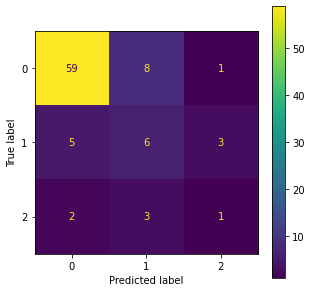

----------------------------------
              precision    recall  f1-score   support

           0       0.60      0.87      0.71        68
           1       0.34      0.35      0.35        68
           2       0.34      0.18      0.23        68

    accuracy                           0.47       204
   macro avg       0.43      0.47      0.43       204
weighted avg       0.43      0.47      0.43       204

----------------------------------


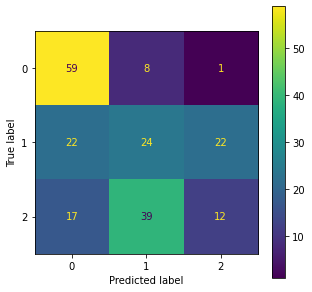

-----------------------------------


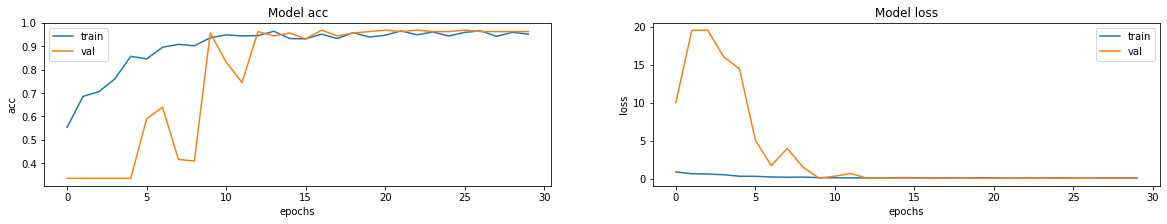

In [12]:
# For first fold
r1 = results[0]
print('Test Loss: ', r1.test_loss)
print('Test Accuracy: ', r1.test_accuracy)
print('----------------------------------')
print(classification_report(r1.y_test, r1.y_pred))
print('----------------------------------')
cm = confusion_matrix(r1.y_test, r1.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r1.y_test_smote, r1.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r1.y_test_smote, r1.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('-----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r1.model_history[metric])
    ax[i].plot(r1.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.5070167779922485
Test Accuracy:  0.7931034564971924
----------------------------------
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        67
           1       0.53      0.64      0.58        14
           2       0.33      0.50      0.40         6

    accuracy                           0.79        87
   macro avg       0.60      0.66      0.62        87
weighted avg       0.83      0.79      0.81        87

----------------------------------


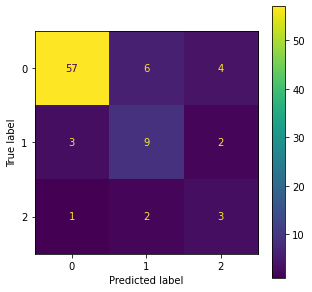

----------------------------------
              precision    recall  f1-score   support

           0       0.84      0.85      0.84        67
           1       0.57      0.76      0.65        67
           2       0.72      0.46      0.56        67

    accuracy                           0.69       201
   macro avg       0.71      0.69      0.69       201
weighted avg       0.71      0.69      0.69       201

----------------------------------


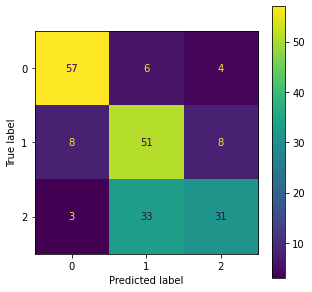

----------------------------------


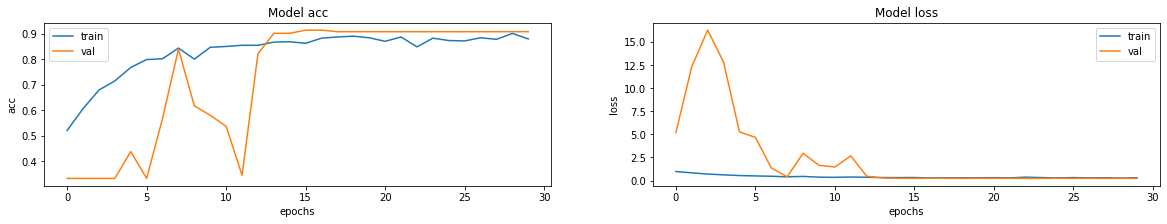

In [13]:
# For second fold
r2 = results[1]
print('Test Loss: ', r2.test_loss)
print('Test Accuracy: ', r2.test_accuracy)
print('----------------------------------')
print(classification_report(r2.y_test, r2.y_pred))
print('----------------------------------')
cm = confusion_matrix(r2.y_test, r2.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r2.y_test_smote, r2.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r2.y_test_smote, r2.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r2.model_history[metric])
    ax[i].plot(r2.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.5678632259368896
Test Accuracy:  0.8160919547080994
----------------------------------
              precision    recall  f1-score   support

           0       0.88      0.96      0.91        67
           1       0.50      0.43      0.46        14
           2       0.50      0.17      0.25         6

    accuracy                           0.82        87
   macro avg       0.63      0.52      0.54        87
weighted avg       0.79      0.82      0.80        87

----------------------------------


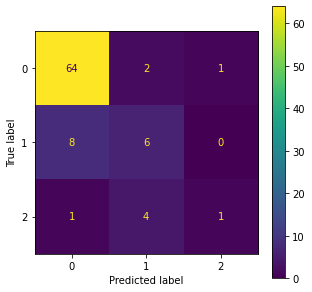

----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        67
           1       0.44      0.70      0.54        67
           2       0.90      0.13      0.23        67

    accuracy                           0.60       201
   macro avg       0.70      0.60      0.54       201
weighted avg       0.70      0.60      0.54       201

----------------------------------


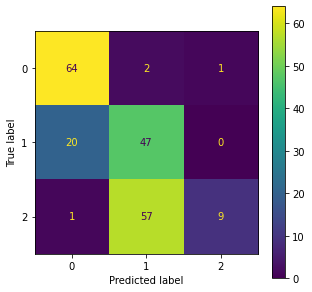

----------------------------------


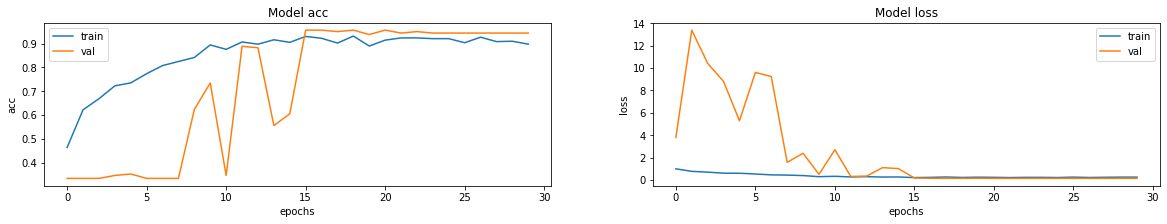

In [14]:
# For third fold
r3 = results[2]
print('Test Loss: ', r3.test_loss)
print('Test Accuracy: ', r3.test_accuracy)
print('----------------------------------')
print(classification_report(r3.y_test, r3.y_pred))
print('----------------------------------')
cm = confusion_matrix(r3.y_test, r3.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r3.y_test_smote, r3.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r3.y_test_smote, r3.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r3.model_history[metric])
    ax[i].plot(r3.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.566455066204071
Test Accuracy:  0.7701149582862854
----------------------------------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        67
           1       0.42      0.36      0.38        14
           2       0.20      0.17      0.18         6

    accuracy                           0.77        87
   macro avg       0.50      0.48      0.49        87
weighted avg       0.75      0.77      0.76        87

----------------------------------


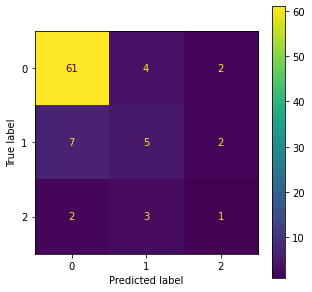

----------------------------------
              precision    recall  f1-score   support

           0       0.61      0.91      0.73        67
           1       0.49      0.45      0.47        67
           2       0.82      0.49      0.62        67

    accuracy                           0.62       201
   macro avg       0.64      0.62      0.61       201
weighted avg       0.64      0.62      0.61       201

----------------------------------


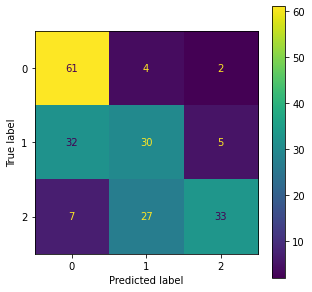

----------------------------------


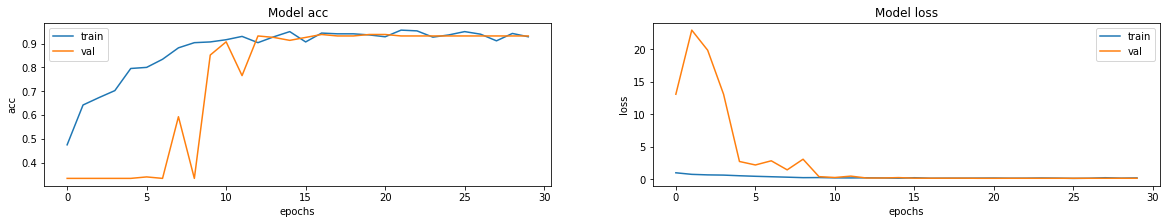

In [15]:
# For fourth fold
r4 = results[3]
print('Test Loss: ', r4.test_loss)
print('Test Accuracy: ', r4.test_accuracy)
print('----------------------------------')
print(classification_report(r4.y_test, r4.y_pred))
print('----------------------------------')
cm = confusion_matrix(r4.y_test, r4.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r4.y_test_smote, r4.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r4.y_test_smote, r4.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r4.model_history[metric])
    ax[i].plot(r4.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.46250149607658386
Test Accuracy:  0.7816091775894165
----------------------------------
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        67
           1       0.53      0.57      0.55        14
           2       0.22      0.33      0.27         6

    accuracy                           0.78        87
   macro avg       0.56      0.59      0.57        87
weighted avg       0.81      0.78      0.79        87

----------------------------------


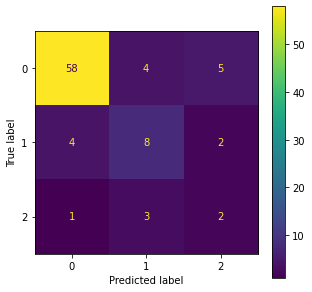

----------------------------------
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        67
           1       0.56      0.75      0.64        67
           2       0.70      0.46      0.56        67

    accuracy                           0.69       201
   macro avg       0.71      0.69      0.69       201
weighted avg       0.71      0.69      0.69       201

----------------------------------


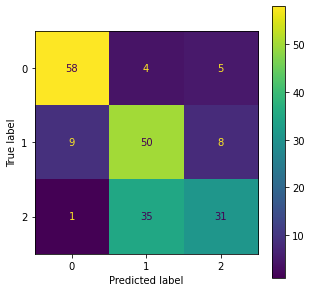

----------------------------------


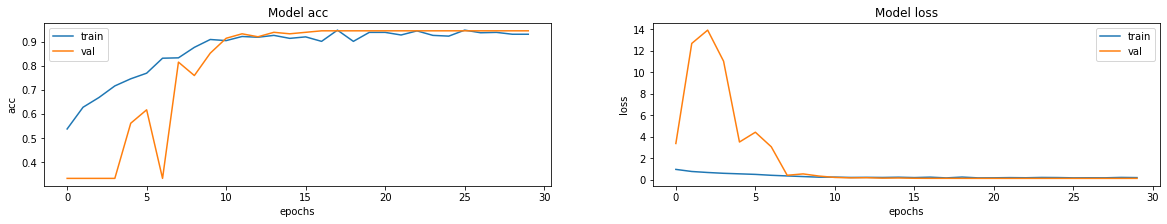

In [16]:
# For fifth fold
r5 = results[4]
print('Test Loss: ', r5.test_loss)
print('Test Accuracy: ', r5.test_accuracy)
print('----------------------------------')
print(classification_report(r5.y_test, r5.y_pred))
print('----------------------------------')
cm = confusion_matrix(r5.y_test, r5.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r5.y_test_smote, r5.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r5.y_test_smote, r5.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r5.model_history[metric])
    ax[i].plot(r5.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [17]:
model.summary()

Model: "3dcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 44, 52, 44,  0                                            
__________________________________________________________________________________________________
conv3d_24 (Conv3D)              (None, 44, 52, 44, 6 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv3d_25 (Conv3D)              (None, 44, 52, 44, 6 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv3d_26 (Conv3D)              (None, 44, 52, 44, 6 1792        input_5[0][0]                    
______________________________________________________________________________________________

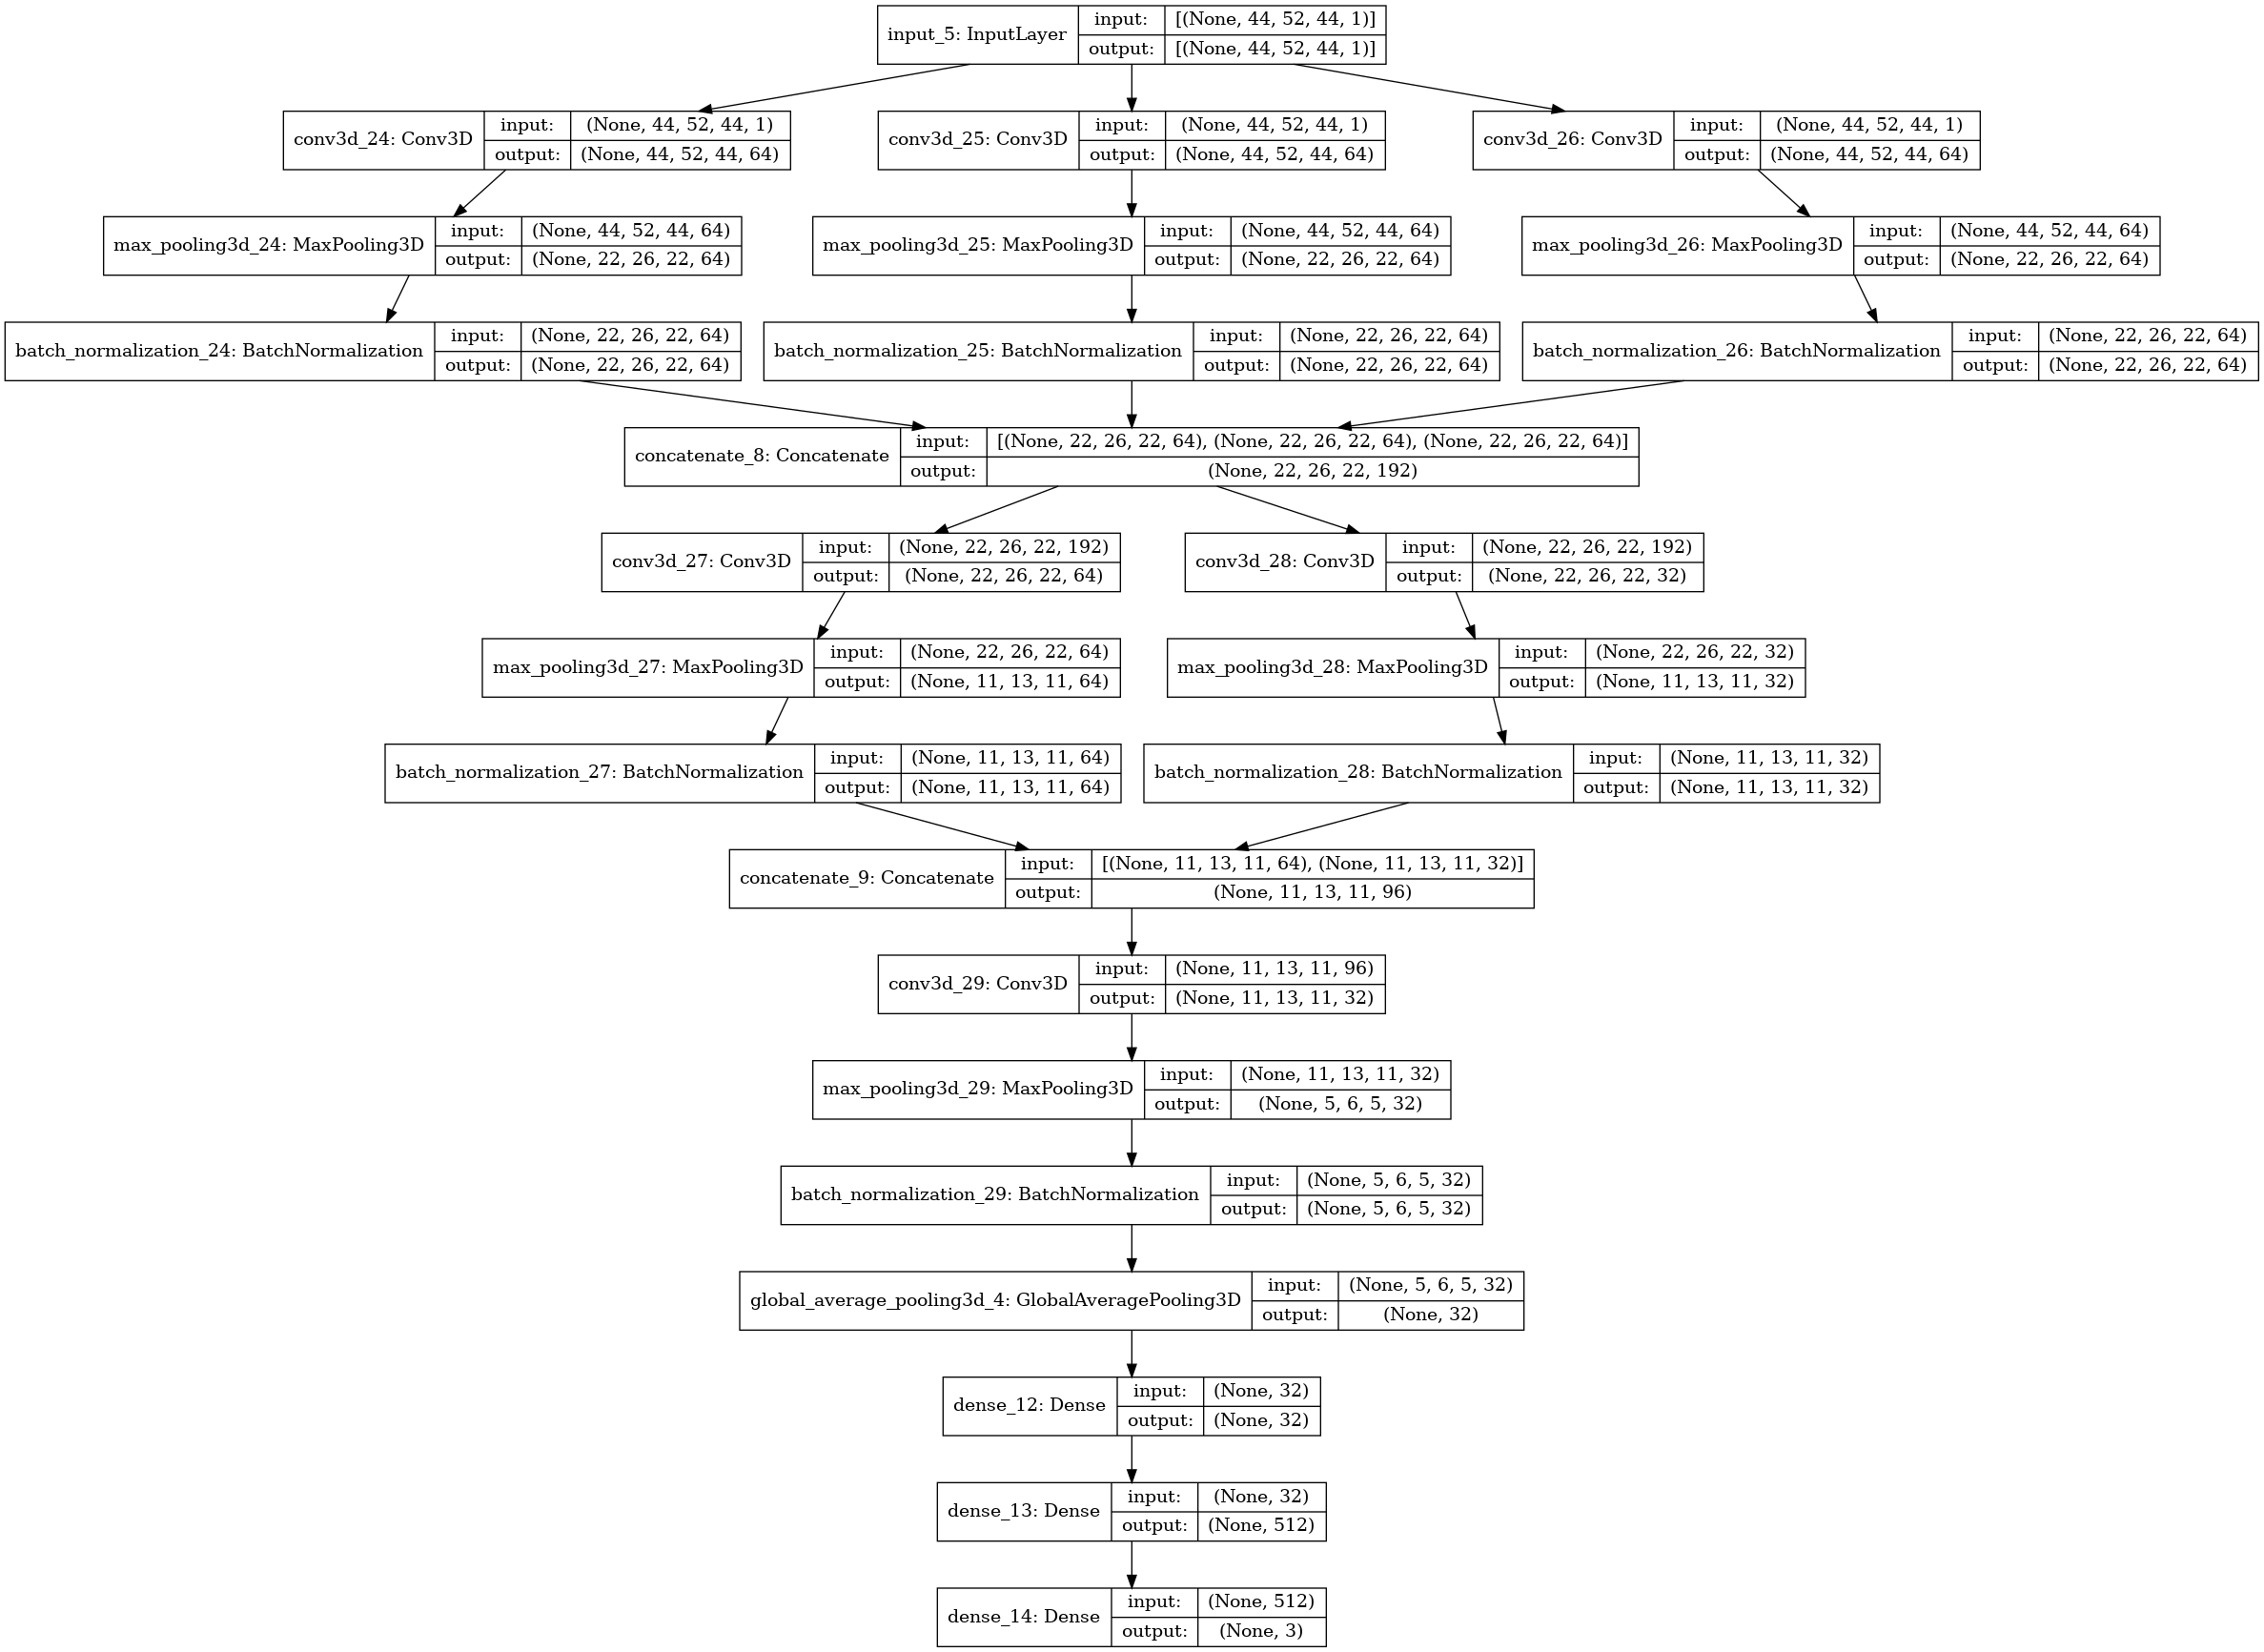

In [18]:
keras.utils.plot_model(model, to_file='image-model.png', show_shapes=True, show_layer_names=True)